## PART 1: CORRELATION STUDY
In order to perform correlation study we used the following data:
* 101 features extracted from Google trends
* *year* and *state_id* feature that let us take advantage of time and location of the state
* *latitude* and *longitude* features that we are able to use to specify geographical position more explicitly
* *income* and *employment* from US Census Bureau
* percentage of people without health insurance
* two target values: *crude prevalence*, *age-adjusted prevalence*

To have a better view of the big images please see inside ../images/

In [1]:
%matplotlib inline  
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

In [ ]:
def build_year_corr(data, year):
    '''
    extract subsample of data and compute the correlation with the ground truth
    '''
    
    data201x=data[data["year"]==year]
    p_a=data201x["prevalence_a"]
    p_c=data201x["prevalence_c"]
    
    cols=data201x.columns
    corr_df=pd.DataFrame(columns=["p_a"+str(year), "p_c"+str(year)], index=cols)
    P_a=[]
    P_c=[]
    for c in cols:
        P_a.append(np.corrcoef(data201x[c].values, p_c)[0,1])
        P_c.append(np.corrcoef(data201x[c].values, p_a)[0,1])
        
    corr_df["p_a"+str(year)] = P_a
    corr_df["p_c"+str(year)] = P_c
    return corr_df

def main_corr(data, years):

    corr_df=pd.DataFrame()
    for y in years:
        corr_temp=build_year_corr(data, y)
        corr_df=pd.concat([corr_df, corr_temp], 1)
    return corr_df


In [2]:
data=pd.read_csv("../data/matrix/matrix_df_163.csv", index_col=0)
data = data.fillna(data.mean())

In [3]:
years=[2011, 2012, 2013, 2014, 2015, 2016]

In [4]:
data.head()

addiction  alcohol  america  animal  antidepressants  anxiety  \
Alabama            72       76       45      73               85       76   
Alaska             74       93       65      83               68       71   
Arizona            76       77       84      71               71       78   
Arkansas           73       73       62      73               82       79   
California         64       77       88      64               56       68   

            app  ashwagandha  association  attack     ...      years  zoloft  \
Alabama      84           48           65      87     ...         91      79   
Alaska       75           69           94      95     ...         82      53   
Arizona      81           98           51      85     ...         86      64   
Arkansas     83           51           74      84     ...         89      77   
California   91           62           40      78     ...         84      49   

            prevalence_a  prevalence_c  income  insurance  unemployment  \
Alabama             21.1          21.2   42590  10.135784      5.926667   
Alaska              16.5          16.5   57431  10.135784      5.926667   
Arizona             17.3          17.5   48621  10.135784      5.926667   
Arkansas            22.9          22.8   41302  10.135784      5.926667   
California          12.1          12.3   53367  10.135784      5.926667   

            states   latitude   longitude  
Alabama          0  32.806671  -86.791130  
Alaska           1  61.370716 -152.404419  
Arizona          2  33.729759 -111.431221  
Arkansas         3  34.969704  -92.373123  
California       4  36.116203 -119.681564  

[5 rows x 163 columns]

### 1. We investigate feature correlation with crude prevalence over the years

In [8]:
x=[i for i in range(len(corr_df.index))]

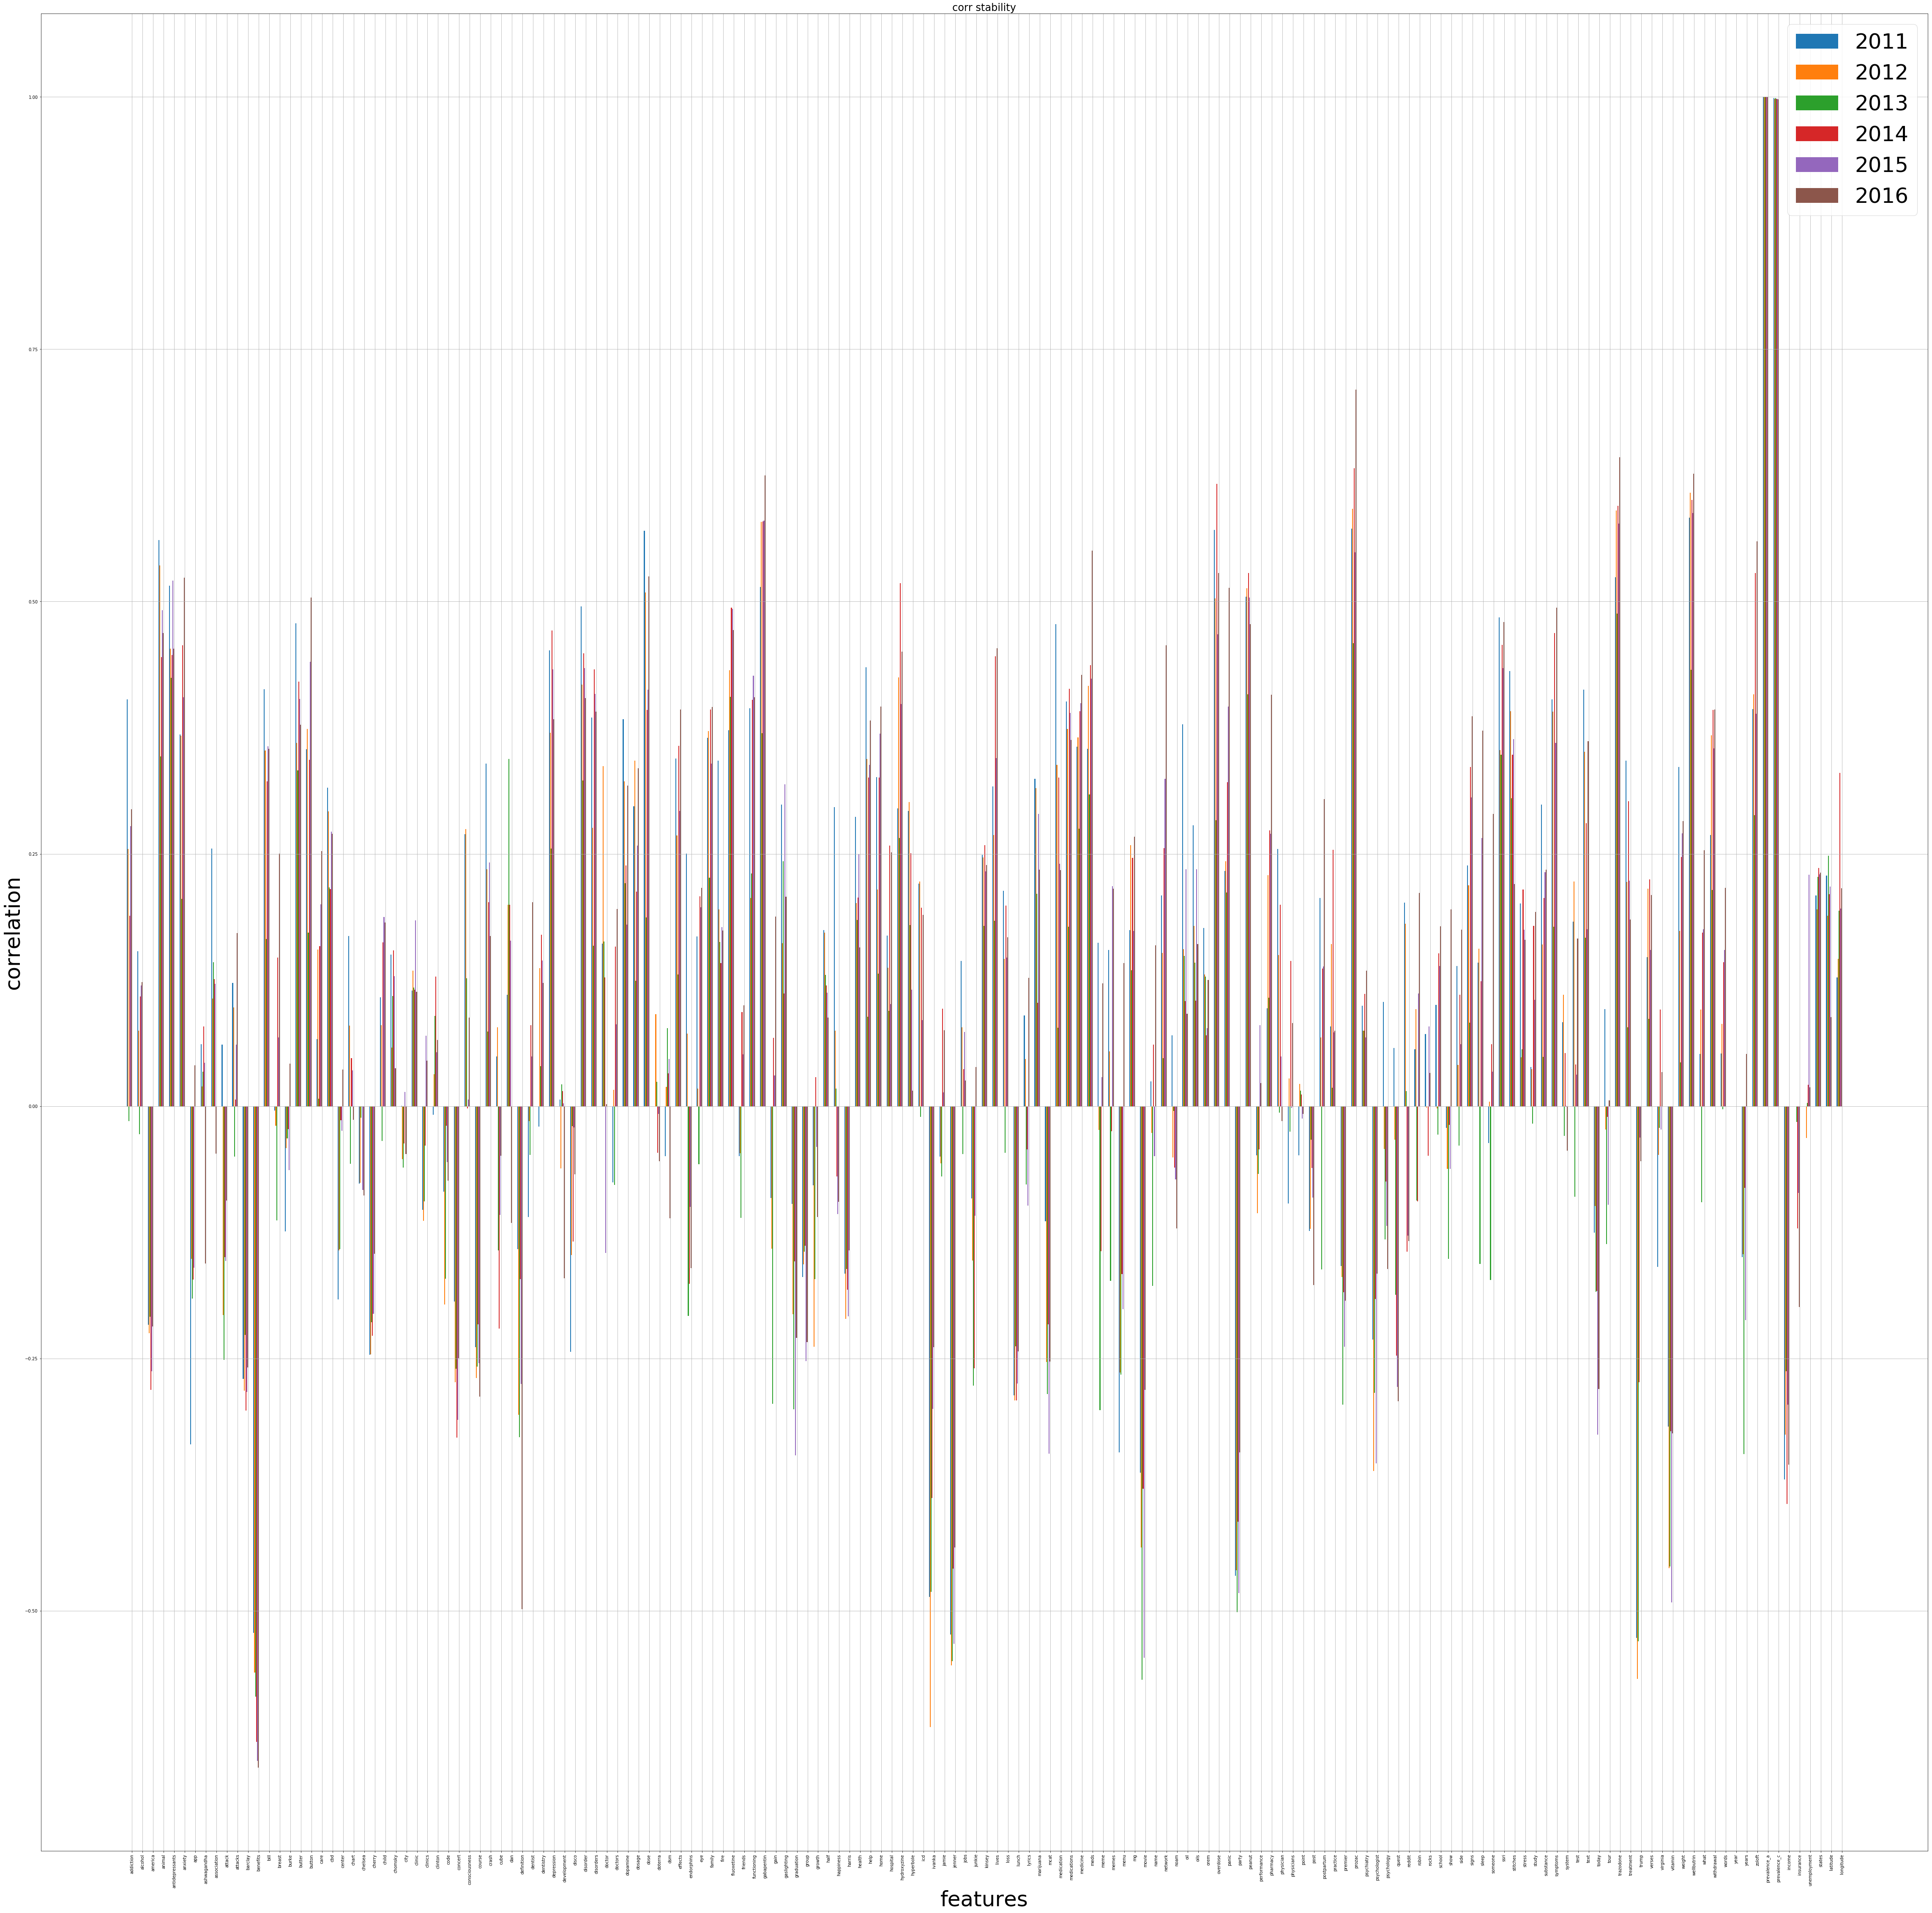

In [11]:
plt.figure(figsize=(80, 80))
t=0
index=corr_df.index
n=len(x)*len(years)*4
for y in range(len(years)):
    x_temp=[i+t for i in range(0,n, len(years)*4)]
    plt.bar(x_temp, corr_df["p_c"+str(years[y])], width=-2, align="edge", tick_label=index)
    t=t+2
plt.title("corr stability", fontsize=50)
plt.xticks(rotation=90)
plt.xlabel('features', fontsize=50)
plt.ylabel('correlation', fontsize=50)
plt.legend(years, fontsize=50, loc=1)
plt.grid()
plt.savefig("corr.pdf", format="pdf")
plt.show()

The plot above is better to explore on a big screen, but anyway, the main idea behind it was to show a correlation between features and one of the target values (crude prevalence in this case) year-wise. It's clear that there is a high variation in correlation for a single feature, but from this plot, we can't tell exactly how big is it comparing to other features and thus we decided to try another way to estimate this quantity (plot below)

### 2. We investigate max correlation variability across different years

In [12]:
n=len(x)*4

In [13]:
x_large=[i for i in range(0,n, 4)]

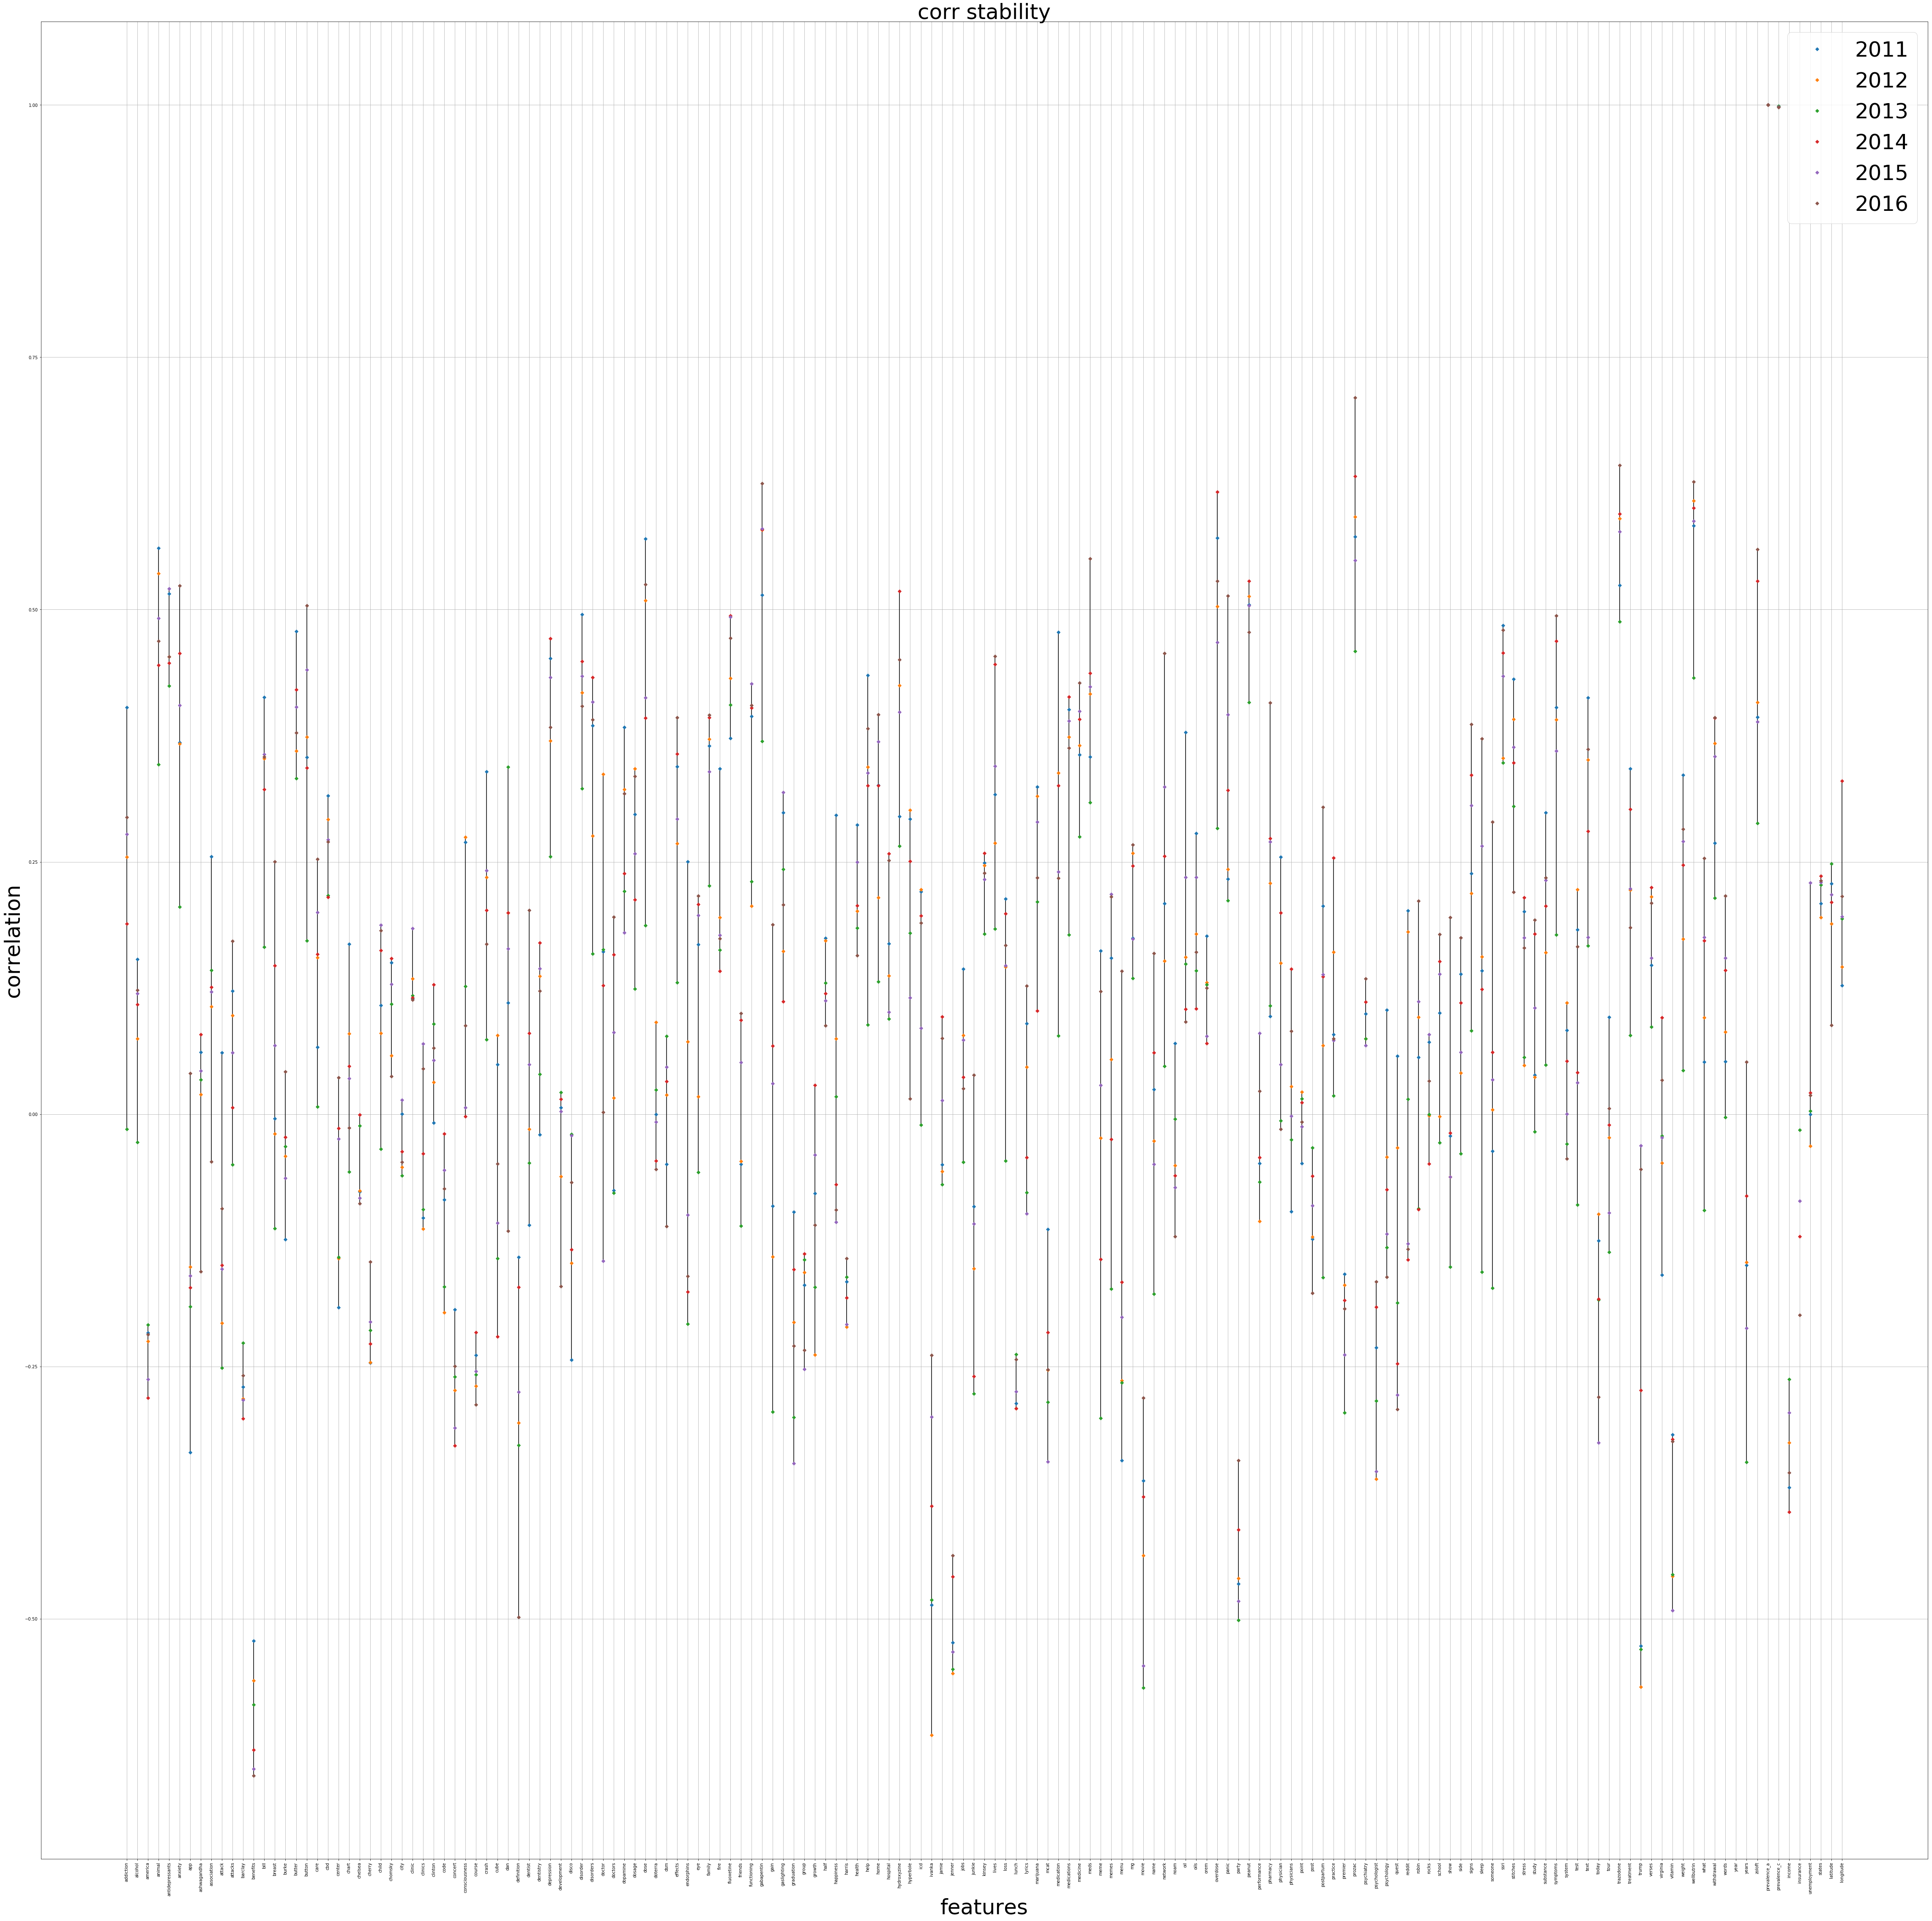

In [15]:
plt.figure(figsize=(80, 80))
for y in range(len(years)):
    plt.plot(x_large, corr_df["p_c"+str(years[y])], "D")
    
corr_df_c=corr_df[["p_c2011", "p_c2012", "p_c2013", "p_c2014", "p_c2015", "p_c2016"]]
for i in range(len(x_large)):
    values=corr_df_c.iloc[x[i],:].values
    v_max=max(values)
    v_min=min(values)
    plt.vlines(x=x_large[i], ymin=v_min, ymax=v_max)
    
plt.xticks(rotation=90)
plt.title("corr stability", fontsize=50)
plt.xlabel('features', fontsize=50)
plt.ylabel('correlation', fontsize=50)
plt.legend(years, fontsize=50, loc=1)
plt.xticks(x_large, index, rotation='vertical')
plt.grid()
plt.savefig("corr_plot.pdf", format="pdf")
plt.show()

At this plot, it's even more clear that in average the correlations are mostly unstable across years and hence we can't consider any model that won't take into account time variable or average features over the years for example.

### 3. We investigate pairwise correlation between features
As we reported before, the data should be analized along with timing variable and thus we put the data for each year together and made a heat-map of it

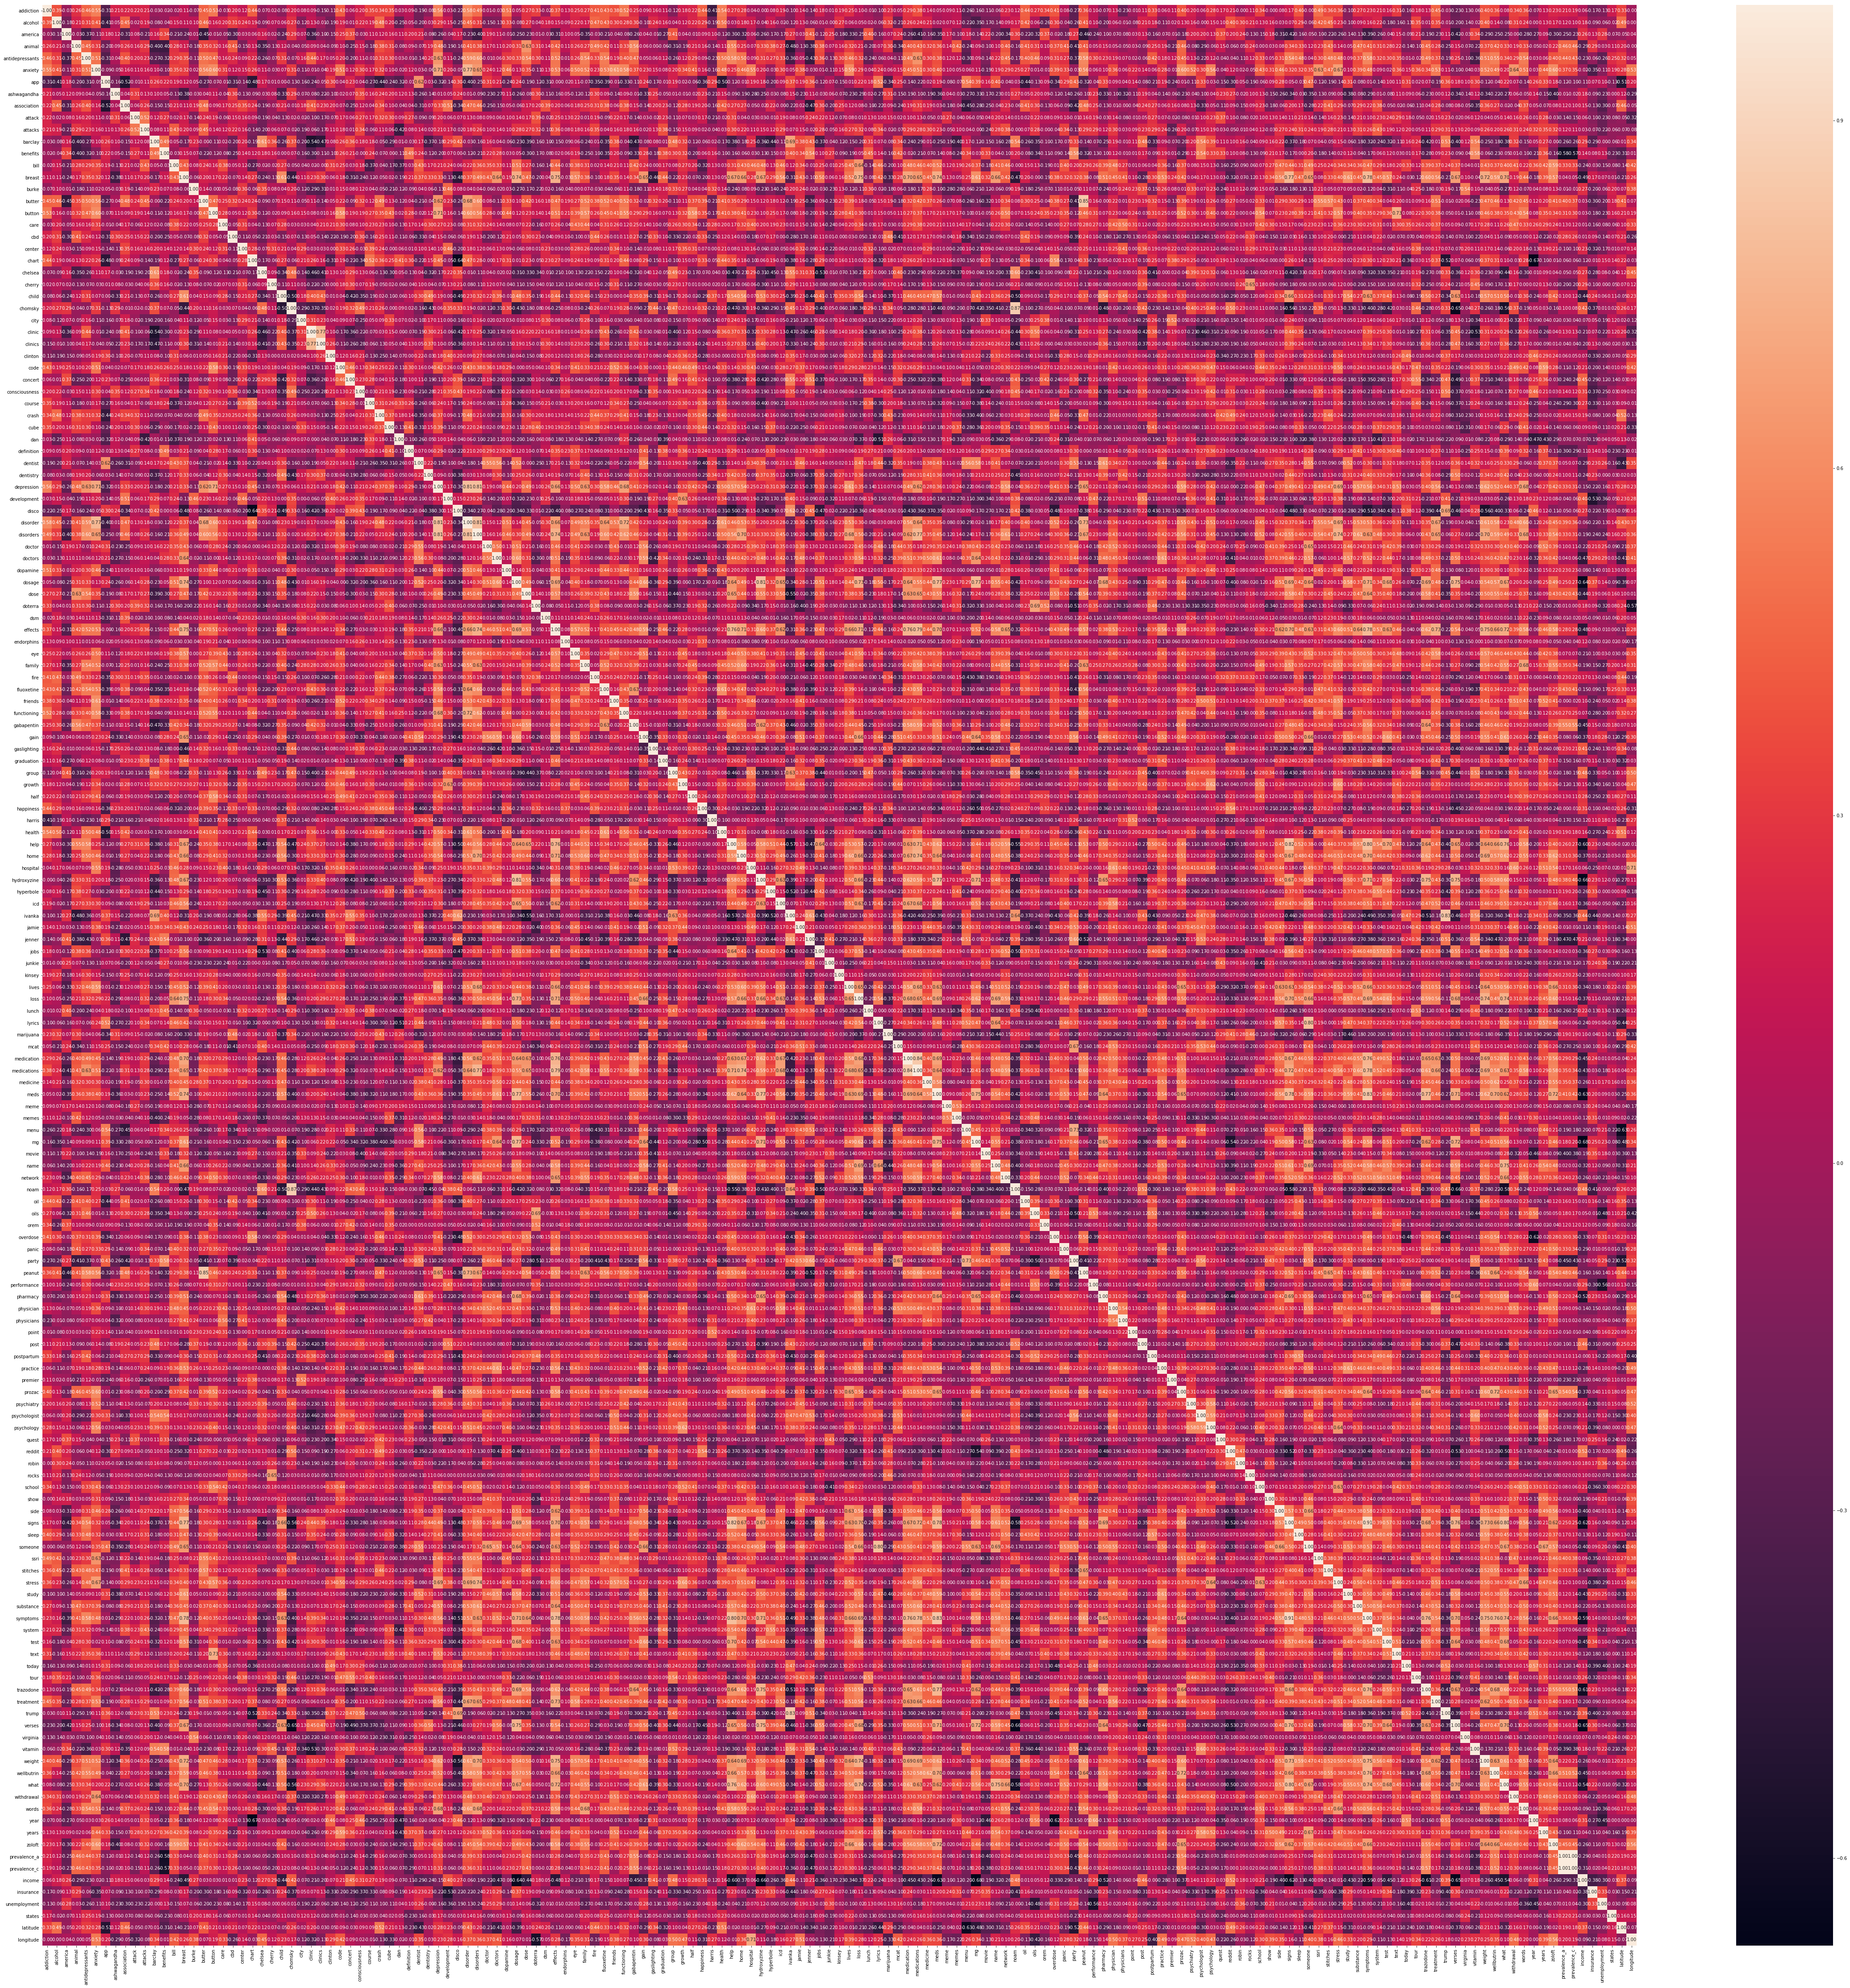

In [167]:
plt.figure(figsize=(80, 80))

corrs=data.corr()
sns.heatmap(corrs, annot=True, fmt=".2f")
plt.savefig("heat.pdf", format="pdf")
plt.show()

It's not easy to perform visual analysis of highly dimentional data, but we clearly can see that there are variables weakly correlated between each other while they have quite high correlation with the target variables and this is the result we were expecting to achieve with the approach we used to collect features from Google Trends

### 4. Investigate pairwise correlation to identify more unstable correlations over the years

In [10]:
years = [2011,2012,2013,2014,2015,2016]
trends = []
for year in years:
    df = data[data["year"] == year]
    df = df.drop(['year'],axis = 1)
    trends.append(df)

In [11]:
to_test = {}
for i in range(len(trends)):
    c = trends[i].corr()
    for col in range(len(data.columns)-1):
        for row in range(len(data.columns)-1):
            if col<row:
                name = data.columns[col] +" "+ data.columns[row]
                if to_test.get(name) == None:
                    to_test[name] = [c.iloc[row,col]]
                else:
                    to_test[name].append(c.iloc[row,col])     

In [13]:
std = dict()
for key in to_test.keys():
    std[key] = np.std(to_test[key])
    

In [20]:
print("Highly unstable trough years:")
m = np.mean(list(std.values()))
s = np.std(list(std.values()))
for key in std.keys():
    if std[key]>m+3*s:
        print(key)

Highly unstable trough years:
memes reddit
attacks pills
dan people
test video
attacks birthday
ashwagandha oils
medication video
meme psychology
adults video
dank depression
dan stress
definition people
endorphins nance
meds memes
dan disorder
oils signs
meme signs
system video
crash dan
cbd disorders
cbd stress
child meme
help memes
dan health
attack video
ashwagandha memes
meme memory
birthday ebola
clinic memes
children video
child memes
autism dan
dank kid
memes pills
dank postpartum
meme video
kid video
memes pregnancy
memes symptoms
anxiety dan
meme reddit
stress video
people video
medications video
dan depression
dan sleep
dan todd
treatment video
drug memes
definition video
teeth video
diet video
dan video
cbd nursing
panic video
meme pregnancy
cbd depression
memes what
cat dan
memes talk
attacks test
button video
help video
ebola party
dank stress
code dan
someone video
oils psych
depression video
video what
amnesia memes
memes signs


In the list abowe we see relations between features that changing a lot over the years

### 4. Correlation with census data: heat map

In [33]:
data_sample=data[["unemployment", "prevalence_a", "prevalence_c", "income", "insurance", "year"]]

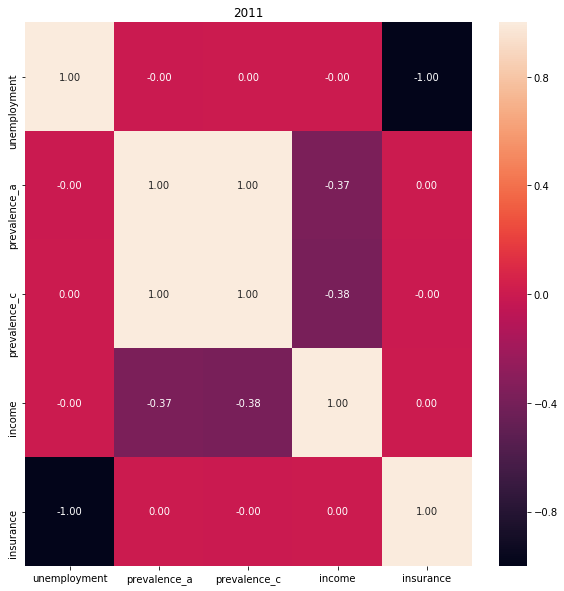

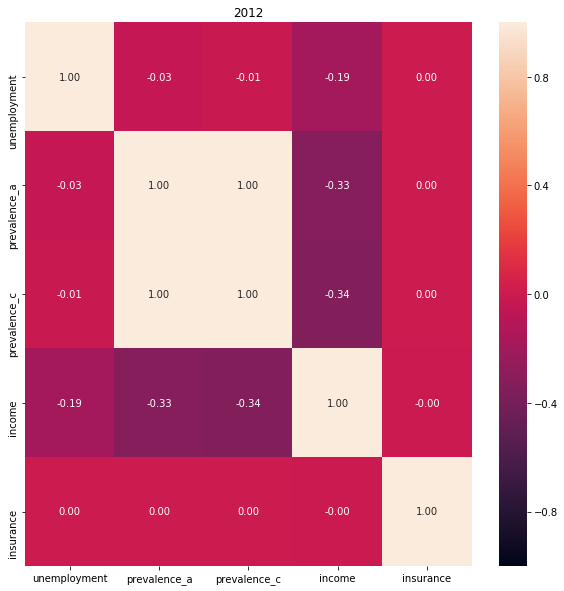

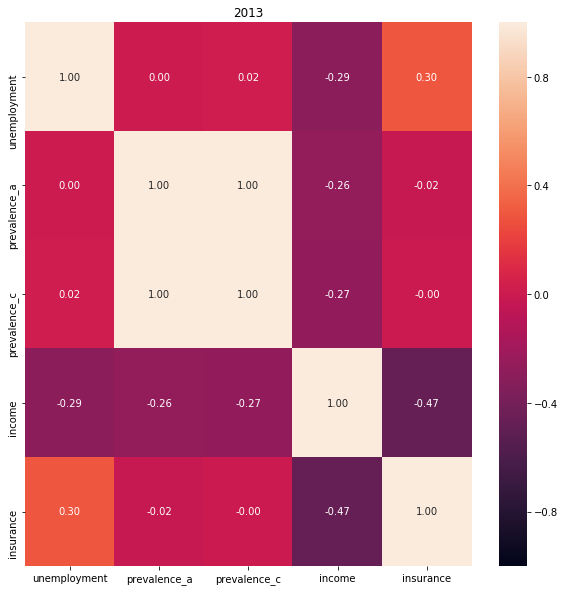

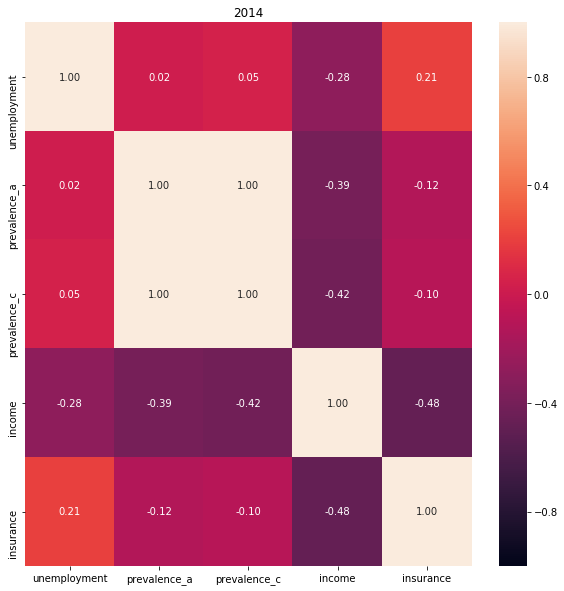

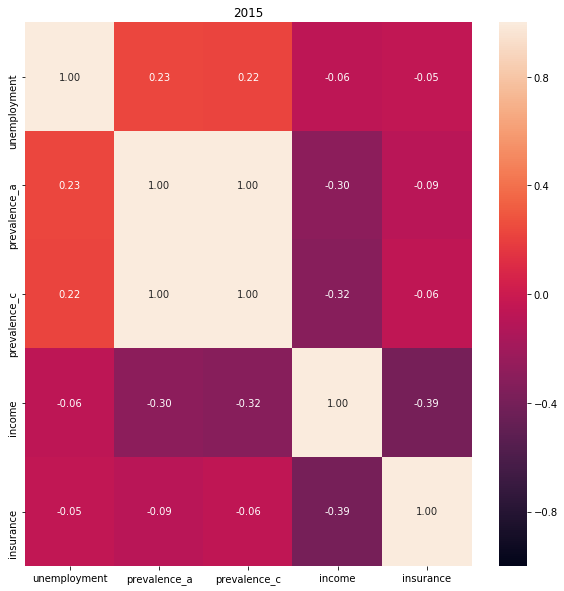

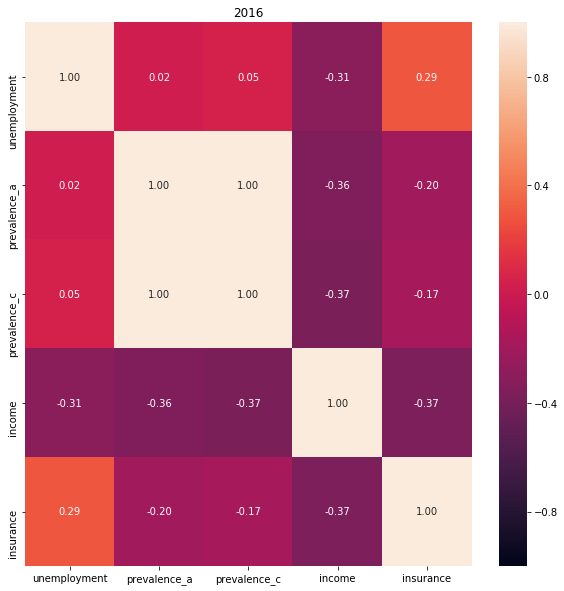

In [32]:
for y in years:
    plt.figure(figsize=(10, 10))
    data_y=data_sample[data_sample["year"]==y]
    data_y=data_y[["unemployment", "prevalence_a", "prevalence_c", "income", "insurance"]]
    corrs=data_y.corr()
    sns.heatmap(corrs, annot=True, fmt=".2f",  vmin=-1, vmax=+1)
    plt.title(y)
    #plt.savefig("heat.pdf", format="pdf")
plt.show()

Some unusual numbers (as for instance insurance-unemployment correlation equal to -1 in 2011) can be explained by the missing data for this year. Apart from this fact, we don't see a strong correlation with any of target values, although we can see that income data stably shows some significant connection with the target values.

### 4. Correlation with census data: census data vs prevalence

In [6]:
cols=["income", "insurance", "unemployment"]

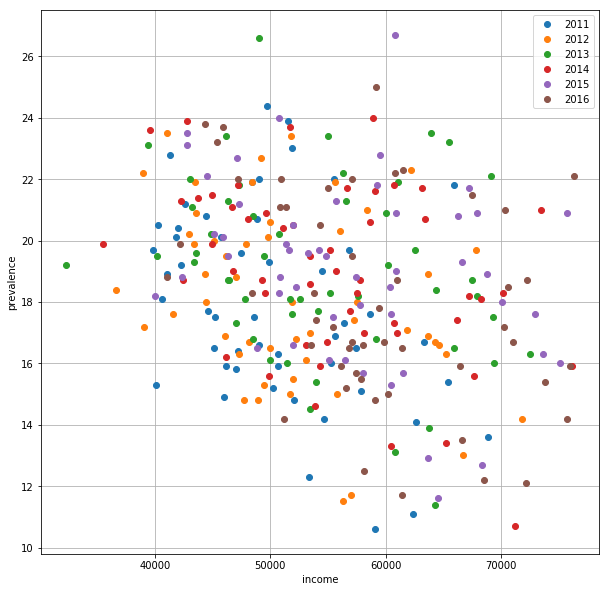

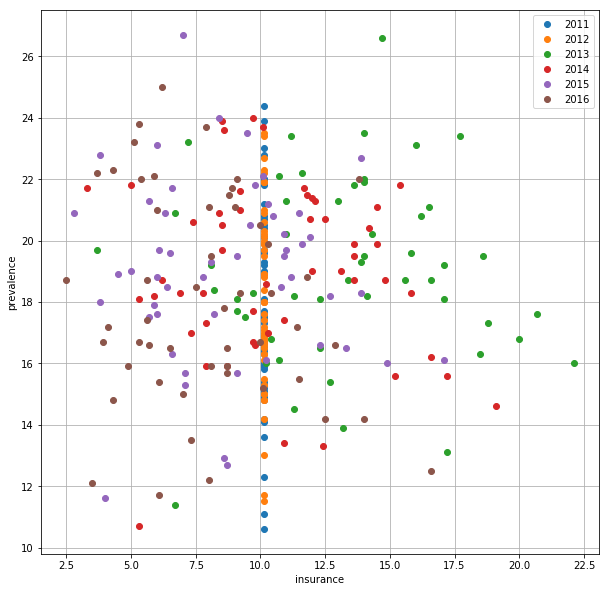

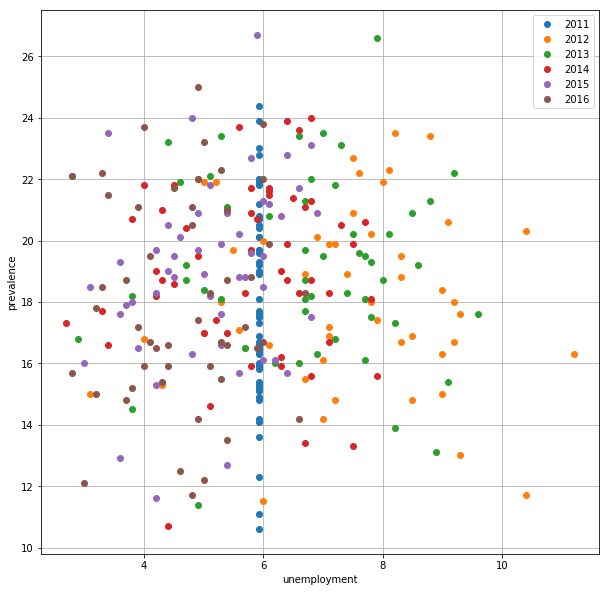

In [16]:
for c in cols:
    plt.figure(figsize=(10, 10))
    for y in years:
        x=data[data["year"]==y][c].values
        y=data[data["year"]==y]["prevalence_c"].values
        plt.plot(x, y, "o")
    plt.ylabel("prevalence")
    plt.xlabel(c)
    plt.legend(years)
    plt.grid()

With imcome-prevalence plot we can see a weak negative trend all other features doesn't show any visuable connection.

We decided to consider all the features for our model: the variability in correlation across years is huge and hense we will apply a sparsity method to deal with the variables.